In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
pd.options.display.max_columns = 5

import os
import glob

In [80]:
def calc_wap(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

In [81]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))
def count_unique(series):
    return len(np.unique(series))

In [82]:
# data directory
data_dir = '/optiver-realized-volatility-prediction/'

In [83]:
book_train = pd.read_parquet("book_train.parquet/stock_id=15")
book_train.head()

,time_id,seconds_in_bucket,...,bid_size2,ask_size2
0,5,0,...,2,12
1,5,1,...,100,20
2,5,2,...,400,20
3,5,3,...,1,20
4,5,4,...,400,20


In [84]:
def preprocessor_book(file_path):
    df = pd.read_parquet(file_path)
    #calculate return etc
    df['wap'] = calc_wap(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return).values
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return).values
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

In [85]:
%%time
file_path = "book_train.parquet/stock_id=0"
preprocessor_book(file_path)

CPU times: total: 3.69 s
Wall time: 3.69 s


,log_return_realized_volatility,log_return2_realized_volatility,...,wap_mean_300,row_id
0,0.004499,0.006999,...,1.003753,0-5
1,0.001204,0.002476,...,1.000397,0-11
2,0.002369,0.004801,...,0.998685,0-16
3,0.002574,0.003637,...,0.998436,0-31
4,0.001894,0.003257,...,0.999488,0-62
...,...,...,...,...,...
3825,0.002579,0.003821,...,0.997519,0-32751
3826,0.002206,0.002847,...,1.000682,0-32753
3827,0.002913,0.003266,...,1.000111,0-32758
3828,0.003046,0.005105,...,1.002277,0-32763


In [86]:
trade_train = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train.head(15)

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
5,5,78,1.003762,134,5
6,5,122,1.004207,102,3
7,5,127,1.004577,1,1
8,5,144,1.004370,6,1
9,5,147,1.003964,233,4


In [87]:
def preprocessor_trade(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return).values
    
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

In [88]:
%%time
file_path ="trade_train.parquet/stock_id=0"
preprocessor_trade(file_path)

CPU times: total: 1.59 s
Wall time: 1.59 s


,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,...,trade_order_count_mean_300,row_id
0,0.002006,40,...,2.571429,0-5
1,0.000901,30,...,2.250000,0-11
2,0.001961,25,...,3.166667,0-16
3,0.001561,15,...,5.111111,0-31
4,0.000871,22,...,4.909091,0-62
...,...,...,...,...,...
3825,0.001519,52,...,3.257143,0-32751
3826,0.001411,28,...,4.250000,0-32753
3827,0.001521,36,...,3.727273,0-32758
3828,0.001794,53,...,1.920000,0-32763


In [89]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp],axis=0)
    
    for stock_id in list_stock_ids:
        df = for_joblib(stock_id)
    
 #   df =  pd.concat(df,ignore_index = True)
    return df

In [90]:
list_stock_ids = [0,1]
preprocessor(list_stock_ids, is_train = True)

,log_return_realized_volatility,log_return2_realized_volatility,...,trade_size_sum_300,trade_order_count_mean_300
0,0.004499,0.006999,...,1587.0,2.571429
1,0.001204,0.002476,...,900.0,2.250000
2,0.002369,0.004801,...,1189.0,3.166667
3,0.002574,0.003637,...,1556.0,5.111111
4,0.001894,0.003257,...,1219.0,4.909091
...,...,...,...,...,...
3825,0.003723,0.004996,...,1889.0,3.608696
3826,0.010829,0.012168,...,30858.0,8.136364
3827,0.003135,0.004268,...,980.0,2.727273
3828,0.003750,0.005773,...,8274.0,2.701754


In [91]:
train = pd.read_csv(data_dir + 'train.csv')

In [92]:
train_ids = train.stock_id.unique()

In [93]:
%%time
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

CPU times: total: 11min 8s
Wall time: 10min 31s


In [94]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')

In [95]:
df_train.head()

,row_id,target,...,trade_size_sum_300,trade_order_count_mean_300
0,0-5,0.004136,...,1587.0,2.571429
1,0-11,0.001445,...,900.0,2.250000
2,0-16,0.002168,...,1189.0,3.166667
3,0-31,0.002195,...,1556.0,5.111111
4,0-62,0.001747,...,1219.0,4.909091


In [96]:
#test
test = pd.read_csv(data_dir + 'test.csv')

test_ids = test.stock_id.unique()

In [97]:
%%time
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

CPU times: total: 46.9 ms
Wall time: 46 ms


In [98]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')

In [99]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

In [100]:
df_train.head()

,row_id,target,...,stock_id,stock_id_target_enc
0,0-5,0.004136,...,0,0.004041
1,0-11,0.001445,...,0,0.004039
2,0-16,0.002168,...,0,0.004041
3,0-31,0.002195,...,0,0.004013
4,0-62,0.001747,...,0,0.004032


In [101]:
df_test.head()

,stock_id,time_id,...,trade_order_count_mean_300,stock_id_target_enc
0,0,4,...,NaN,0.004028
1,0,32,...,NaN,0.004028
2,0,34,...,NaN,0.004028


In [102]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

In [103]:
import lightgbm as lgbm

In [104]:
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [105]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300', 'stock_id', 'stock_id_target_enc'],
      dtype='object')

In [106]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [107]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [108]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

params = {
      "objective": "rmse", 
      "metric": "rmse", 
      "boosting_type": "gbdt",
      'early_stopping_rounds': 30,
      'learning_rate': 0.01,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
  }

In [109]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=4011, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []

In [110]:
from lightgbm import log_evaluation, early_stopping

In [111]:
%%time
for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)

    # model 
    model = lgbm.train(params=params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      callbacks=[log_evaluation(100)],
                      categorical_feature = ['stock_id']                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')
    
    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

Fold : 1


d:\miniconda\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 28
[LightGBM] [Info] Start training from score 0.001799
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659768	training's RMSPE: 0.30544	valid_1's rmse: 0.000660856	valid_1's RMSPE: 0.30548
[200]	training's rmse: 0.000535736	training's RMSPE: 0.24802	valid_1's rmse: 0.000539892	valid_1's RMSPE: 0.24956
[300]	training's rmse: 0.000509967	training's RMSPE: 0.23609	valid_1's rmse: 0.000516832	valid_1's RMSPE: 0.2389
[400]	training's rmse: 0.000502408	training's RMSPE: 0.23259	valid_1's rmse: 0.000511079	valid_1's RMSPE: 0.23624
[500]	training's rmse: 0.000498528	training's RMSPE: 0.2308	valid_1's rmse: 0.000508759	valid_1's RMSPE: 0.23517
[600]	training's rmse: 0.000

d:\miniconda\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 28
[LightGBM] [Info] Start training from score 0.001799
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659655	training's RMSPE: 0.30546	valid_1's rmse: 0.000663508	valid_1's RMSPE: 0.30643
[200]	training's rmse: 0.000535598	training's RMSPE: 0.24801	valid_1's rmse: 0.000541384	valid_1's RMSPE: 0.25003
[300]	training's rmse: 0.000509773	training's RMSPE: 0.23605	valid_1's rmse: 0.000516781	valid_1's RMSPE: 0.23867
[400]	training's rmse: 0.000502181	training's RMSPE: 0.23254	valid_1's rmse: 0.000510534	valid_1's RMSPE: 0.23578
[500]	training's rmse: 0.000498329	training's RMSPE: 0.23075	valid_1's rmse: 0.000508397	valid_1's RMSPE: 0.2348
[600]	training's rmse: 0.00

d:\miniconda\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6997
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 28
[LightGBM] [Info] Start training from score 0.001798
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659654	training's RMSPE: 0.30544	valid_1's rmse: 0.000659532	valid_1's RMSPE: 0.30467
[200]	training's rmse: 0.000535245	training's RMSPE: 0.24783	valid_1's rmse: 0.000540149	valid_1's RMSPE: 0.24952
[300]	training's rmse: 0.000509342	training's RMSPE: 0.23584	valid_1's rmse: 0.000517173	valid_1's RMSPE: 0.23891
[400]	training's rmse: 0.000501658	training's RMSPE: 0.23228	valid_1's rmse: 0.00051155	valid_1's RMSPE: 0.23631
[500]	training's rmse: 0.000497716	training's RMSPE: 0.23046	valid_1's rmse: 0.000509171	valid_1's RMSPE: 0.23521
[600]	training's rmse: 0.00

d:\miniconda\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 28
[LightGBM] [Info] Start training from score 0.001798
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000659265	training's RMSPE: 0.30537	valid_1's rmse: 0.000663139	valid_1's RMSPE: 0.30587
[200]	training's rmse: 0.000535106	training's RMSPE: 0.24786	valid_1's rmse: 0.000542512	valid_1's RMSPE: 0.25024
[300]	training's rmse: 0.000509297	training's RMSPE: 0.23591	valid_1's rmse: 0.000518461	valid_1's RMSPE: 0.23914
[400]	training's rmse: 0.000501771	training's RMSPE: 0.23242	valid_1's rmse: 0.000512113	valid_1's RMSPE: 0.23621
[500]	training's rmse: 0.00049783	training's RMSPE: 0.2306	valid_1's rmse: 0.000509478	valid_1's RMSPE: 0.235
[600]	training's rmse: 0.00049

d:\miniconda\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 28
[LightGBM] [Info] Start training from score 0.001807
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.000658939	training's RMSPE: 0.30431	valid_1's rmse: 0.000674077	valid_1's RMSPE: 0.31463
[200]	training's rmse: 0.000535588	training's RMSPE: 0.24735	valid_1's rmse: 0.00055539	valid_1's RMSPE: 0.25923
[300]	training's rmse: 0.000509867	training's RMSPE: 0.23547	valid_1's rmse: 0.000531731	valid_1's RMSPE: 0.24819
[400]	training's rmse: 0.000502408	training's RMSPE: 0.23202	valid_1's rmse: 0.000525549	valid_1's RMSPE: 0.24531
[500]	training's rmse: 0.000498531	training's RMSPE: 0.23023	valid_1's rmse: 0.000524289	valid_1's RMSPE: 0.24472
Early stopping, best iterat

In [112]:
scores

0.235

In [113]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

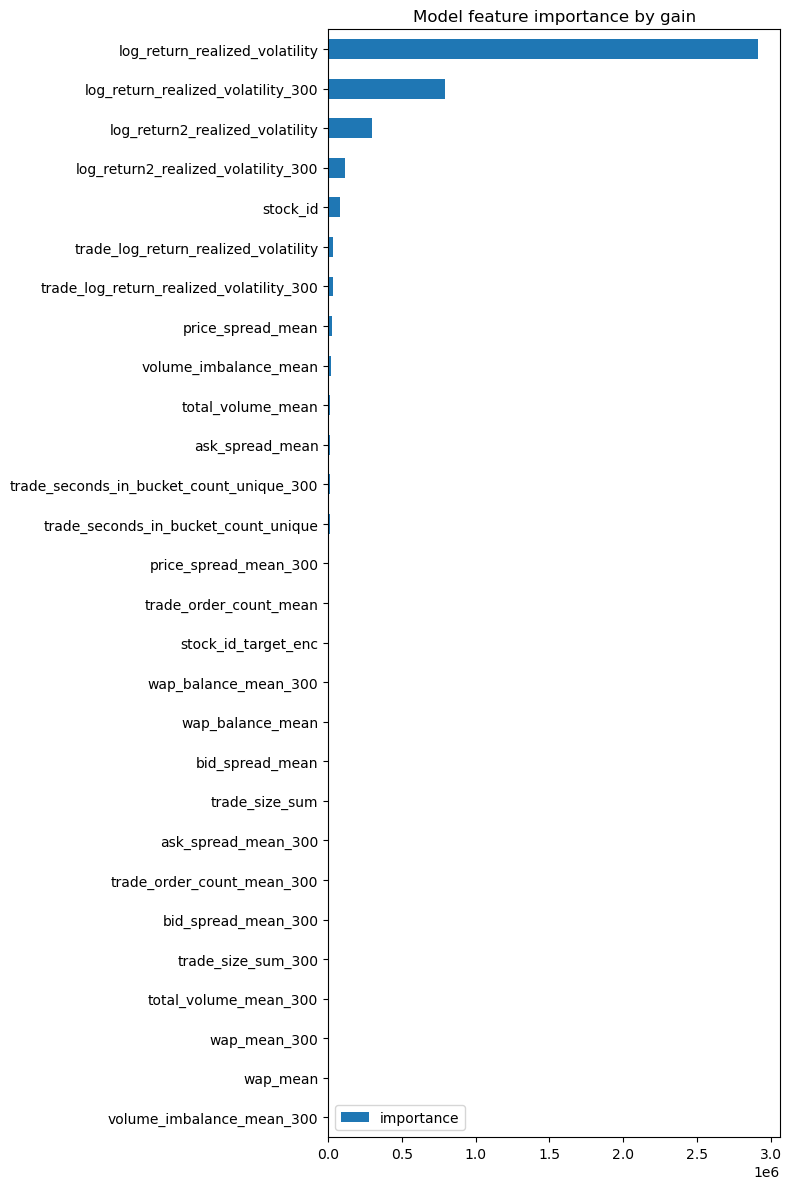

In [114]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

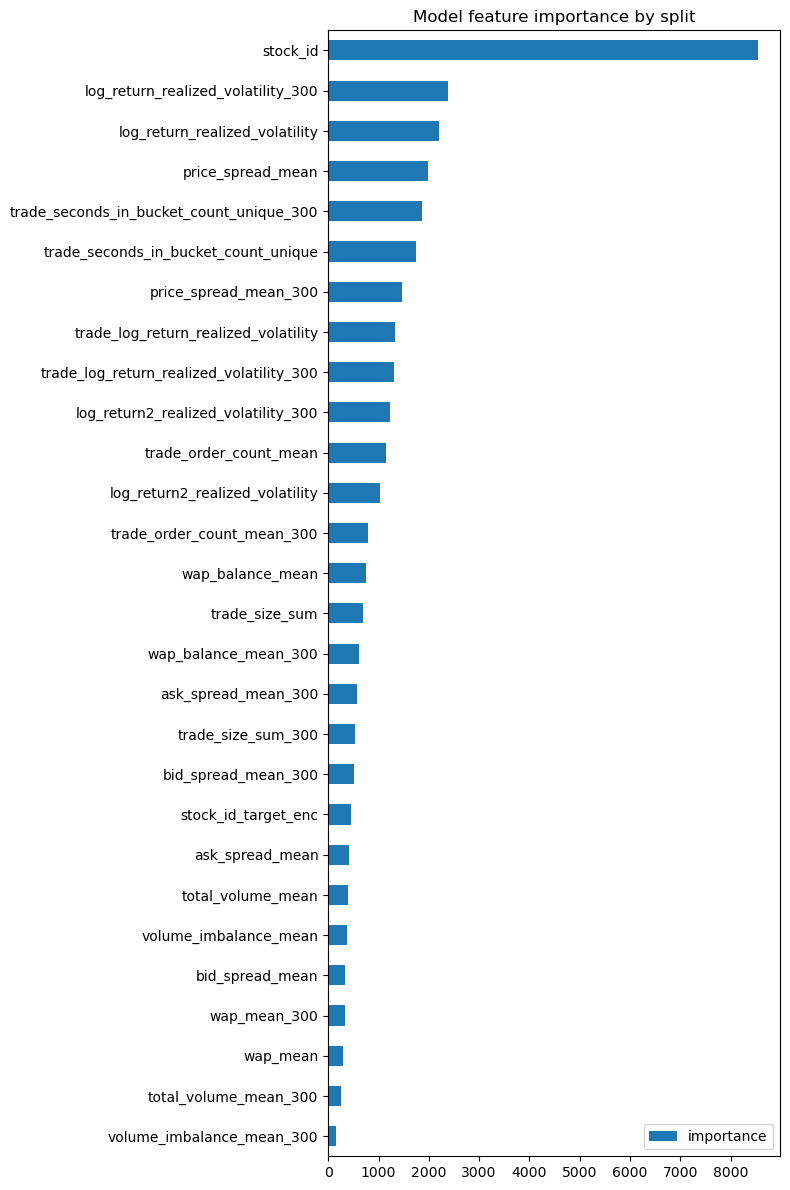

In [115]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

In [116]:
df_test.columns

Index(['stock_id', 'time_id', 'row_id', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300', 'stock_id_target_enc'],
      dtype='object')

In [117]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_seconds_in_bucket_count_unique_300', 'trade_size_sum_300',
       'trade_order_count_mean_300', 'stock_id', 'stock_id_target_enc'],
      dtype='object')

In [118]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis = 1)

In [119]:
X_test

,stock_id,log_return_realized_volatility,...,trade_order_count_mean_300,stock_id_target_enc
0,0,0.000294,...,NaN,0.004028
1,0,NaN,...,NaN,0.004028
2,0,NaN,...,NaN,0.004028


In [120]:
target = np.zeros(len(X_test))

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [121]:
y_pred = y_pred.assign(target = target)

In [122]:
y_pred

,row_id,target
0,0-4,0.000953
1,0-32,0.000850
2,0-34,0.000850


In [123]:
y_pred.to_csv('submission.csv',index = False)